In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/Data'
# images_directory = os.path.join(root, 'image_dataset')
# masks_directory = os.path.join(root, 'mask_dataset')

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_CLASSES = 6
NUM_TRAIN_IMAGES = 336
NUM_VAL_IMAGES = 25

In [ ]:
train_images = sorted(glob(os.path.join(DATA_DIR, "image_dataset/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "mask_dataset2/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "image_dataset/*")))[
    NUM_TRAIN_IMAGES:
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "mask_dataset2/*")))[
    NUM_TRAIN_IMAGES:
]
print(len(train_images), len(val_images))

336 25


In [ ]:
# def preprocess_mask(mask):
#     #mask = mask.astype(np.int32)
#     #mask[mask != 3] = 0
#     mask[ (mask == 0) | (mask == 1) | (mask == 3) | (mask == 4) | (mask == 5) | (mask == 8) | (mask == 10)
#      | (mask == 11) | (mask == 13) | (mask == 14) | (mask == 15) | (mask == 16) | (mask == 17) | (mask == 18) | (mask == 19) | (mask == 20)
#       | (mask == 21) | (mask == 23) | (mask == 24)] = 0
#     mask[mask == 2] = 1 # grass
#     mask[mask == 9] = 2 # dog
#     mask[mask == 6] = 3 # tree
#     mask[mask == 7] = 4 # sky
#     mask[ (mask == 12) | (mask == 22)] = 5 # concrete/walkway
    
#     return mask
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.0
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.map(Augment())
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <MapDataset shapes: ((4, 256, 256, 3), (4, 256, 256, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <MapDataset shapes: ((4, 256, 256, 3), (4, 256, 256, 1)), types: (tf.float32, tf.float32)>


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [ ]:
!pip install segmentation-models

In [ ]:
import segmentation_models as sm

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=np.array(weights)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics=['accuracy', sm.metrics.IOUScore(threshold=0.5),]


In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3
n_classes = 6
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
# #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_171 (Conv2D)            (None, 256, 256, 16  448         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_81 (Dropout)           (None, 256, 256, 16  0           ['conv2d_171[0][0]']             
                                )                                                           

In [ ]:
import glob
import cv2
from PIL import Image
msk_names = glob.glob('/content/drive/MyDrive/Data/mask_dataset/*.png')
# f = r'/content/drive/MyDrive/Data/mask_dataset'
# for mask in os.listdir(f):
#     f_img = f+"/"+mask
#     # name = mask[:4]
#     # with open(f_img, 'rb') as file:
#     # msk = Image.open(f_img)
#     msk = cv2.imread(f_img, cv2.IMREAD_UNCHANGED)
#     msk = preprocess_mask(msk)
#     #msk = msk.resize((256,256))
#     msk = np.array(msk)
    
    # img = Image.fromarray(msk)
    # img.save('/content/drive/MyDrive/Data/mask_dataset2/' + mask)
# dest = '/content/drive/MyDrive/Data/mask_dataset2/'
# for mask in msk_names:
#     name = mask.rsplit('/', 1)[1]
#     # name = mask[-4:]
#     with open(mask, 'rb') as file:
#         msk = Image.open(file)
#         # msk = msk.resize((256,256))
#         msk = np.array(msk)
#         msk = preprocess_mask(msk)
#         img = Image.fromarray(msk)
#         img.save(dest + name)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=35)

Epoch 1/35
84/84 [==============================] - 16s 154ms/step - loss: 18.7583 - accuracy: 0.0069 - iou_score: 2.6442e-04 - val_loss: 11.1117 - val_accuracy: 8.8819e-04 - val_iou_score: 1.3643e-12
Epoch 2/35
84/84 [==============================] - 12s 147ms/step - loss: 18.6742 - accuracy: 0.0011 - iou_score: 7.2280e-13 - val_loss: 11.1116 - val_accuracy: 1.8438e-04 - val_iou_score: 1.3643e-12
Epoch 3/35
84/84 [==============================] - 12s 142ms/step - loss: 18.6740 - accuracy: 7.5517e-04 - iou_score: 7.2280e-13 - val_loss: 11.1116 - val_accuracy: 9.0917e-05 - val_iou_score: 1.3643e-12
Epoch 4/35
84/84 [==============================] - 12s 145ms/step - loss: 18.6740 - accuracy: 5.5236e-04 - iou_score: 7.2280e-13 - val_loss: 11.1116 - val_accuracy: 5.2770e-05 - val_iou_score: 1.3643e-12
Epoch 5/35
84/84 [==============================] - 12s 144ms/step - loss: 18.6740 - accuracy: 0.1368 - iou_score: 7.2280e-13 - val_loss: 11.1116 - val_accuracy: 2.2888e-05 - val_iou_score

In [ ]:
model.save('/content/drive/MyDrive/Data/WOWmodel.hdf5')

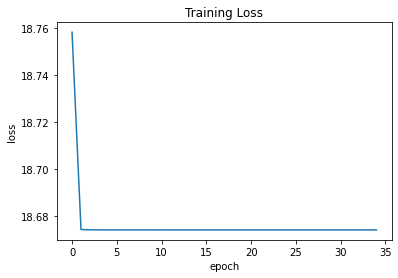

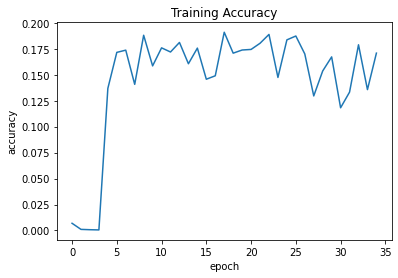

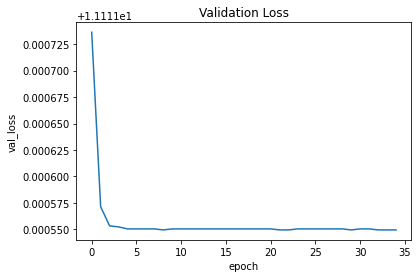

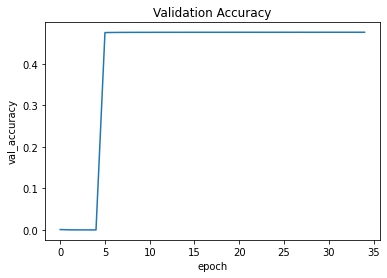

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
# Loading the Colormap
colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

FileNotFoundError: ignored